In [18]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==== USER PATHS ====
source_dir = "C:\\Users\\LENOVO\\OneDrive - Faculty of Engineering Ain Shams University\\Desktop\\CV Project\\UCF101"          # original dataset
split_dir  = "C:\\Users\\LENOVO\\OneDrive - Faculty of Engineering Ain Shams University\\Desktop\\CV Project\\UCF101-split"     # output split dataset

# ==== TRAIN/VAL/TEST SPLIT RATIO ====
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15

# ==== VIDEO SETTINGS ====
NB_FRAMES = 16
TARGET_SHAPE = (112, 112)
BATCH_SIZE = 8
NB_CHANNEL = 3
EPOCHS = 12
SEED = 42



In [ ]:
# Create split directories
train_dir = os.path.join(split_dir, "train")
val_dir   = os.path.join(split_dir, "val")
test_dir  = os.path.join(split_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Created split folders inside:", split_dir)


Created split folders inside: C:\Users\LENOVO\OneDrive - Faculty of Engineering Ain Shams University\Desktop\CV Project\UCF101-split


In [ ]:

classes = sorted([d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))])

print("Classes found:", len(classes))

for cls in tqdm(classes):
    class_path = os.path.join(source_dir, cls)

    videos = [v for v in os.listdir(class_path)
              if v.lower().endswith((".avi",".mp4",".mov",".mkv"))]

    random.shuffle(videos)
    
    total = len(videos)
    train_end = int(total * train_ratio)
    val_end   = int(total * (train_ratio + val_ratio))

    train_videos = videos[:train_end]
    val_videos   = videos[train_end:val_end]
    test_videos  = videos[val_end:]

    # Create class directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copy files
    for vid in train_videos:
        shutil.copy(os.path.join(class_path, vid),
                    os.path.join(train_dir, cls, vid))

    for vid in val_videos:
        shutil.copy(os.path.join(class_path, vid),
                    os.path.join(val_dir, cls, vid))

    for vid in test_videos:
        shutil.copy(os.path.join(class_path, vid),
                    os.path.join(test_dir, cls, vid))

print("Dataset successfully split!")



Classes found: 101


100%|██████████| 101/101 [02:39<00:00,  1.58s/it]

Dataset successfully split!


In [19]:
train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05
    
)

test_aug = ImageDataGenerator()


In [20]:
class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, classes, batch_size, nb_frames, target_shape,
                 augmentation=None, shuffle=True):
        
        self.directory = directory
        self.classes = classes
        self.batch_size = batch_size
        self.nb_frames = nb_frames
        self.target_shape = target_shape
        self.augmentation = augmentation
        self.shuffle = shuffle

        self.samples = []
        for label_idx, cls in enumerate(classes):
            cls_path = os.path.join(directory, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".avi", ".mp4", ".mov")):
                    self.samples.append((os.path.join(cls_path, f), label_idx))

        self.on_epoch_end()

    def __len__(self):
        return len(self.samples) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

    def __getitem__(self, idx):
        batch = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]

        X = np.zeros((self.batch_size, self.nb_frames, *self.target_shape, 3), dtype="float32")
        y = np.zeros((self.batch_size,), dtype="int")

        for i, (video_path, label) in enumerate(batch):
            X[i] = self.load_video_frames(video_path)
            y[i] = label

        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def load_video_frames(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            return np.zeros((self.nb_frames, *self.target_shape, 3), dtype="float32")

        start = random.randint(0, max(0, total_frames - self.nb_frames))
        cap.set(cv2.CAP_PROP_POS_FRAMES, start)

        frames = []
        for _ in range(self.nb_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, self.target_shape)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            if self.augmentation:
                frame = self.augmentation.random_transform(frame)

            frame = preprocess_input(frame)
            frames.append(frame)

        cap.release()

        while len(frames) < self.nb_frames:
            frames.append(frames[-1])

        return np.array(frames, dtype="float32")


In [ ]:
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

train_gen = VideoFrameGenerator(train_dir, classes, BATCH_SIZE, NB_FRAMES, TARGET_SHAPE, augmentation=train_aug)
val_gen   = VideoFrameGenerator(val_dir, classes, BATCH_SIZE, NB_FRAMES, TARGET_SHAPE, augmentation=test_aug, shuffle=False)
test_gen  = VideoFrameGenerator(test_dir, classes, BATCH_SIZE, NB_FRAMES, TARGET_SHAPE, augmentation=test_aug, shuffle=False)

len(train_gen), len(val_gen), len(test_gen)


(1160, 249, 255)

In [22]:
def build_cnn_lstm_model(num_classes, unfreeze_last_n=50):
    input_layer = Input(shape=(NB_FRAMES, TARGET_SHAPE[0], TARGET_SHAPE[1], NB_CHANNEL))

    cnn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], 3))

    for layer in cnn_base.layers[:-unfreeze_last_n]:
        layer.trainable = False
    for layer in cnn_base.layers[-unfreeze_last_n:]:
        layer.trainable = True

    x = TimeDistributed(cnn_base)(input_layer)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    x = LSTM(128)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)

    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

model = build_cnn_lstm_model(num_classes)
model.summary()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19144\2003072001.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], 3))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │        13,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,008,933 (11.48 MB)

 Trainable params: 2,606,053 (9.94 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [24]:
# Training with SGD Optimizer

K.clear_session()

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
model = build_cnn_lstm_model(num_classes)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

checkpoint_path = "best_sgd_model.h5"

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("🔵 Training with SGD...")
history_sgd = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
)

model.save("final_sgd_model.h5")
print("SGD training complete!")



C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19144\2003072001.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], 3))


🔵 Training with SGD...


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1311s 1s/step - accuracy: 0.1058 - loss: 4.1230 - val_accuracy: 0.3358 - val_loss: 3.0927
Epoch 2/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 1011s 871ms/step - accuracy: 0.2912 - loss: 2.9624 - val_accuracy: 0.5020 - val_loss: 2.0349
Epoch 3/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 846s 729ms/step - accuracy: 0.4223 - loss: 2.2807 - val_accuracy: 0.5924 - val_loss: 1.5538
Epoch 4/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 808s 697ms/step - accuracy: 0.5151 - loss: 1.8647 - val_accuracy: 0.6571 - val_loss: 1.2460
Epoch 5/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 820s 707ms/step - accuracy: 0.5782 - loss: 1.5668 - val_accuracy: 0.7189 - val_loss: 1.0574
Epoch 6/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 837s 722ms/step - accuracy: 0.6381 - loss: 1.3324 - val_accuracy: 0.7641 - val_loss: 0.8863
Epoch 7/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 880s 759ms/step - accuracy: 0.6871 - loss: 1.1456 - val_accuracy: 0.7721 - val_loss: 0.8475
Epoch 8/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2832s 2s/step - accur

SGD training complete!


In [32]:
# Training with Adam Optimizer
K.clear_session()

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    clipnorm=1.0
)

model = build_cnn_lstm_model(num_classes)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

checkpoint_path = "best_adam_model.h5"

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("🟢 Training with Adam...")
history_adam = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
)

model.save("final_adam_model.h5")
print("Adam training complete!")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19144\2003072001.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], 3))


🟢 Training with Adam...
Epoch 1/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2222s 2s/step - accuracy: 0.0180 - loss: 4.5911 - val_accuracy: 0.0392 - val_loss: 4.5096
Epoch 2/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2125s 2s/step - accuracy: 0.0515 - loss: 4.4351 - val_accuracy: 0.0868 - val_loss: 4.3318
Epoch 3/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2095s 2s/step - accuracy: 0.0860 - loss: 4.2580 - val_accuracy: 0.1526 - val_loss: 4.1133
Epoch 4/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2073s 2s/step - accuracy: 0.1197 - loss: 4.0747 - val_accuracy: 0.2078 - val_loss: 3.9071
Epoch 5/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2090s 2s/step - accuracy: 0.1571 - loss: 3.8894 - val_accuracy: 0.2761 - val_loss: 3.6958
Epoch 6/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2077s 2s/step - accuracy: 0.1967 - loss: 3.7024 - val_accuracy: 0.3293 - val_loss: 3.4840
Epoch 7/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2089s 2s/step - accuracy: 0.2376 - loss: 3.5416 - val_accuracy: 0.3594 - val_loss: 3.3175
Epoch 8/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2070s 2s/s

Adam training complete!


In [33]:
#Training with Adagrad Optimizer
K.clear_session()

optimizer = tf.keras.optimizers.Adagrad()
model = build_cnn_lstm_model(num_classes)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

checkpoint_path = "best_adagrad_model.h5"

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("🟣 Training with Adagrad...")
history_adagrad = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
)

model.save("final_adagrad_model.h5")
print("Adagrad training complete!")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19144\2003072001.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  cnn_base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(TARGET_SHAPE[0], TARGET_SHAPE[1], 3))


🟣 Training with Adagrad...
Epoch 1/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2408s 2s/step - accuracy: 0.0374 - loss: 4.5112 - val_accuracy: 0.0708 - val_loss: 4.3532
Epoch 2/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2163s 2s/step - accuracy: 0.0947 - loss: 4.2012 - val_accuracy: 0.2028 - val_loss: 3.9702
Epoch 3/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2143s 2s/step - accuracy: 0.1745 - loss: 3.8652 - val_accuracy: 0.3107 - val_loss: 3.5635
Epoch 4/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2155s 2s/step - accuracy: 0.2497 - loss: 3.5178 - val_accuracy: 0.3830 - val_loss: 3.1899
Epoch 5/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2142s 2s/step - accuracy: 0.2954 - loss: 3.2386 - val_accuracy: 0.4573 - val_loss: 2.8860
Epoch 6/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3760s 3s/step - accuracy: 0.3411 - loss: 2.9976 - val_accuracy: 0.4940 - val_loss: 2.6475
Epoch 7/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 3517s 3s/step - accuracy: 0.3801 - loss: 2.8074 - val_accuracy: 0.5191 - val_loss: 2.4586
Epoch 8/12
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 2332s 2

Adagrad training complete!


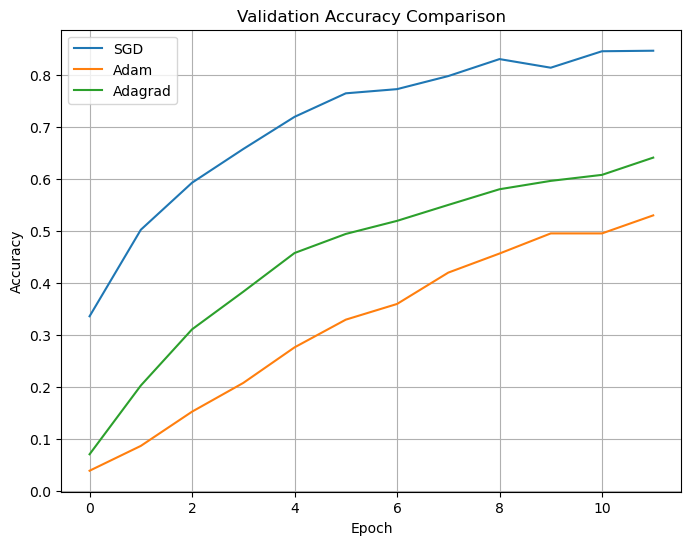

In [34]:
plt.figure(figsize=(8,6))
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.plot(history_adam.history['val_accuracy'], label='Adam')
plt.plot(history_adagrad.history['val_accuracy'], label='Adagrad')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [28]:
#Evaluate Model on Test Set
model = tf.keras.models.load_model("final_sgd_model.h5")

test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)



255/255 ━━━━━━━━━━━━━━━━━━━━ 268s 984ms/step - accuracy: 0.8475 - loss: 0.5367
Test Accuracy: 0.8475490212440491


In [29]:
y_true = []
y_pred = []

for X, y in test_gen:
    preds = model.predict(X, verbose=0)
    
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Done! Collected predictions from test set.")


Done! Collected predictions from test set.



Top 10 most frequent classes in TEST set:
 - CricketShot
 - BoxingPunchingBag
 - Drumming
 - HorseRiding
 - PlayingCello
 - PlayingDhol
 - ShavingBeard
 - TennisSwing
 - BandMarching
 - BenchPress


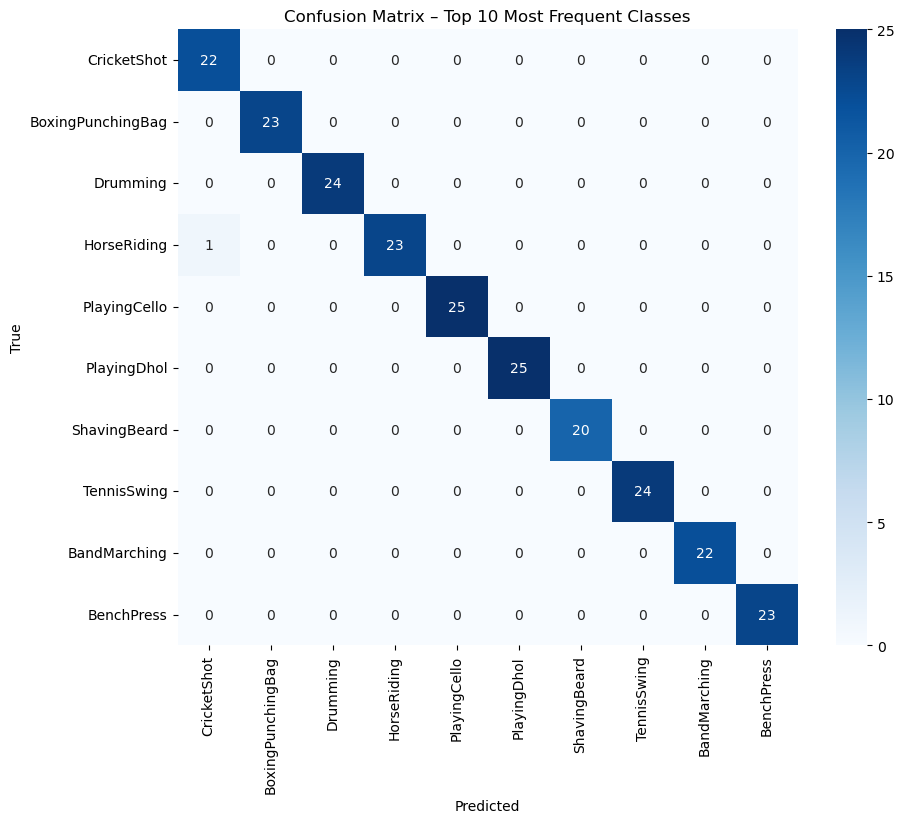

In [30]:
class_counts = {i: 0 for i in range(len(classes))}

for label in y_true:
    class_counts[label] += 1

# CLASS INDICES SORTED BY FREQUENCY (descending)
top10_indices = sorted(class_counts, key=class_counts.get, reverse=True)[:10]
top10_classes = [classes[i] for i in top10_indices]

print("\nTop 10 most frequent classes in TEST set:")
for c in top10_classes:
    print(" -", c)

cm_full = confusion_matrix(y_true, y_pred)

# Extract only the top 10 classes
cm_small = cm_full[np.ix_(top10_indices, top10_indices)]


plt.figure(figsize=(10, 8))
sns.heatmap(cm_small, annot=True, fmt="d", cmap="Blues",
            xticklabels=top10_classes,
            yticklabels=top10_classes)

plt.title("Confusion Matrix – Top 10 Most Frequent Classes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=classes))


                    precision    recall  f1-score   support

    ApplyEyeMakeup       1.00      0.86      0.93        22
     ApplyLipstick       0.69      1.00      0.82        18
           Archery       0.78      0.82      0.80        22
      BabyCrawling       0.94      0.80      0.86        20
       BalanceBeam       1.00      0.47      0.64        17
      BandMarching       0.88      0.92      0.90        24
     BaseballPitch       0.92      0.96      0.94        23
        Basketball       0.62      0.71      0.67        21
    BasketballDunk       0.95      0.95      0.95        20
        BenchPress       1.00      0.96      0.98        24
            Biking       0.91      0.95      0.93        21
         Billiards       1.00      0.87      0.93        23
       BlowDryHair       0.87      0.65      0.74        20
    BlowingCandles       1.00      0.88      0.94        17
  BodyWeightSquats       0.45      0.88      0.60        17
           Bowling       1.00      1.00